In [53]:
# SET WHICH GPU TO USE
import os
import torch 

cuda:1
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
cuda:1
print(torch.cuda.device_count())

# torch.cuda.set_device(1)cuda:1

# import notebook_util
# notebook_util.pick_gpu_lowest_memory()
# import tensorflow as tf 

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

1


In [54]:
import argparse
import logging
import os
import time
from tqdm import tqdm

import apex.amp as amp
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import densenet121 as _densenet
import matplotlib.pyplot as plt


batch_size = 1
data_dir = '/home/mtech/2020/satyaki_ghosh/codes/fastAdvTraining/fast_adversarial/VISION/training_data.npy'
epochs = 1
lr_schedule = 'cyclic'
lr_min = 0
lr_max = 0.04
weight_decay = 5e-4
momentum = 0.9
epsilon = 4   # torch.tensor(0, dtype=torch.int8) 
minibatch_replays = 8
out_dir = 'train_free_output'
seed = 0
opt_level = 'O2'
loss_scale = '1.0'
master_weights = 'store_true'
num_classes = 5
model_name = "densenet"

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [55]:
import os
import random

import apex.amp as amp
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, utils
from tqdm import tqdm

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

vision_mean = (0.4333, 0.4635, 0.4767)
vision_std = (0.2687, 0.2536, 0.2593)

mu = torch.tensor(vision_mean).view(3,1,1).cuda()
std = torch.tensor(vision_std).view(3,1,1).cuda()

upper_limit = ((1 - mu)/ std)
lower_limit = ((0 - mu)/ std)

root_dir = '/home/mtech/2020/satyaki_ghosh/codes/fastAdvTraining/fast_adversarial/VISION'
IMG_SIZE = 224
channels = 3

In [56]:
# LOADING THE DATSET
# with open(os.path.join(root_dir, 'training_data.npy'),'rb') as f:
#     dummy = np.load(f, allow_pickle=True)
# dataset = list(dummy)
# random.shuffle(dataset)
# split_ratio = 0.8
# split_num = int(len(dataset) * split_ratio)
# trainset = dataset[0 : split_num]
# testset = dataset[split_num : ]

In [57]:
class VISIONDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, train=True, root_dir=root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trainset = trainset
        self.testset = testset
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        if self.train:
            return len(self.trainset)
        else: 
            return len(self.testset)

    def __getitem__(self, idx):

        # print(f'Index1: {idx}')
        if torch.is_tensor(idx):            
            idx = idx.tolist()

        # CREATING INPUT AND LABELS
        X = []
        y = []

        # print(f'Index2: {idx}')

        if self.train==True:
            X = self.trainset[idx][0]
            y = self.trainset[idx][1]

        else:
            X = self.testset[idx][0]
            y = self.testset[idx][1]         


        X = np.array(X)
        y = np.array(y)

        if self.transform:
            X = self.transform(X)

        return (X, y)


def clamp(X, lower_limit, upper_limit):
    return torch.max(torch.min(X, upper_limit), lower_limit)


def get_loaders(dir_, batch_size):
    train_transform = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize(vision_mean, vision_std),
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(vision_mean, vision_std),
    ])
    num_workers = 2
    train_dataset = VISIONDataset(
        train=True, transform=train_transform)
    test_dataset = VISIONDataset(
        train=False, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_workers
    )
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        num_workers=num_workers
    )
    return train_loader, test_loader


def attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts, opt=None):
    max_loss = torch.zeros(y.shape[0]).cuda()
    max_delta = torch.zeros_like(X).cuda()
    for zz in range(restarts):
        delta = torch.zeros_like(X).cuda()
        print(delta.shape)
        print(lower_limit.shape)
        for i in range(len(epsilon)):
            delta[:, i, :, :].uniform_(-epsilon[i][0][0].item(), epsilon[i][0][0].item())
        delta.data = clamp(delta, lower_limit - X, upper_limit - X)
        delta.requires_grad = True
        for _ in range(attack_iters):
            output = model(X + delta)
            index = torch.where(output.max(1)[1] == y)
            print(f'INDEX : {index}')
            if len(index[0]) == 0:
                break
            loss = F.cross_entropy(output, y)
#             if opt is not None:
#                 with amp.scale_loss(loss, opt) as scaled_loss:
#                     scaled_loss.backward()
#             else:
#                 loss.backward()
            loss.backward()
            grad = delta.grad.detach()
            d = delta[index[0], :, :, :]
            g = grad[index[0], :, :, :]
            d = clamp(d + alpha * torch.sign(g), -epsilon, epsilon)
            d = clamp(d, lower_limit - X[index[0], :, :, :], upper_limit - X[index[0], :, :, :])
            delta.data[index[0], :, :, :] = d
            delta.grad.zero_()
        all_loss = F.cross_entropy(model(X+delta), y, reduction='none').detach()
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)
    return max_delta


def evaluate_pgd(test_loader, model, attack_iters, restarts):
    epsilon = (8 / 255.) / std
    alpha = (2 / 255.) / std
    pgd_loss = 0
    pgd_acc = 0
    n = 0
    count = 0
    model.eval()
    loop = tqdm(enumerate(test_loader), total = len(test_loader))
    for i, (X, y) in loop:
        if count==10:
            break
        count += 1
        X, y = X.cuda(), y.cuda()
        pgd_delta = attack_pgd(model, X, y, epsilon, alpha, attack_iters, restarts)
        with torch.no_grad():
            output = model(X + pgd_delta)
            loss = F.cross_entropy(output, y)
            pgd_loss += loss.item() * y.size(0)
            pgd_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
        loop.set_description("PGD evaluation:")
    return pgd_loss/n, pgd_acc/n


def evaluate_standard(test_loader, model):
    test_loss = 0
    test_acc = 0
    n = 0
    model.eval()
    with torch.no_grad():
        loop = tqdm(enumerate(test_loader), total = len(test_loader))
        for i, (X, y) in loop:
            X, y = X.cuda(), y.cuda()
            output = model(X)
            loss = F.cross_entropy(output, y)
            test_loss += loss.item() * y.size(0)
            test_acc += (output.max(1)[1] == y).sum().item()
            n += y.size(0)
            loop.set_description("Standard evaluation:")
    return test_loss/n, test_acc/n


def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [58]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    """ Densenet
    """
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

In [59]:
ls

apex/        fast_adversarial/     Visualize_adversarial_images.ipynb
cifar-data/  patch_to_image.ipynb


In [60]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

train_loader, test_loader = get_loaders(data_dir, batch_size)

epsilon = (epsilon / 255.) / std
pgd_alpha = (2 / 255.) / std
IMG_SIZE = 224

# model = _densenet(pretrained=False).cuda()
model = model_ft.cuda()

model.train()

opt = torch.optim.SGD(model.parameters(), lr=lr_max, momentum=momentum, weight_decay=weight_decay)
amp_args = dict(opt_level=opt_level, loss_scale=loss_scale, verbosity=False)
if opt_level == 'O2':
    amp_args['master_weights'] = master_weights
model, opt = amp.initialize(model, opt, **amp_args)
criterion = nn.CrossEntropyLoss()

delta = torch.zeros(batch_size, 3, IMG_SIZE, IMG_SIZE).cuda()
delta.requires_grad = True

lr_steps = epochs * len(train_loader) * minibatch_replays
if lr_schedule == 'cyclic':
    scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=lr_min, max_lr=lr_max,
        step_size_up=lr_steps / 2, step_size_down=lr_steps / 2)
elif lr_schedule == 'multistep':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[lr_steps / 2, lr_steps * 3 / 4], gamma=0.1)

Starting training...


  0%|                                                                                                                                                 | 0/60000 [00:00<?, ?it/s]

IMAGE : 0, LABEL : tensor([1])


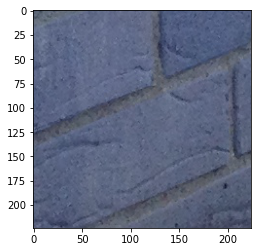

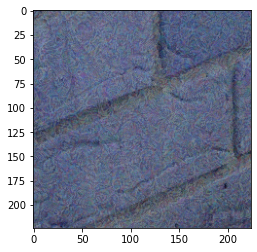

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


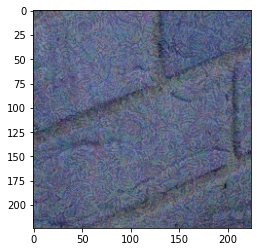

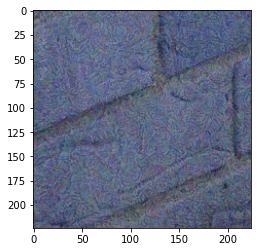

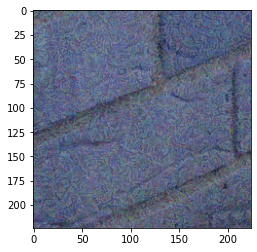

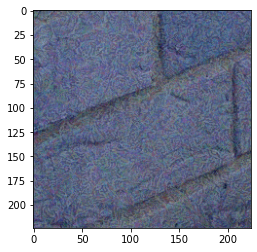

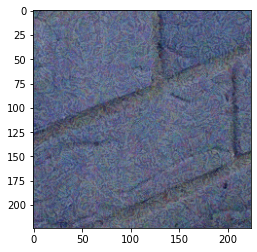

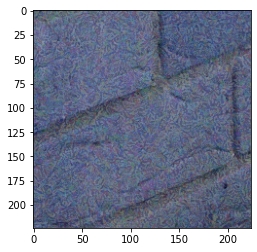

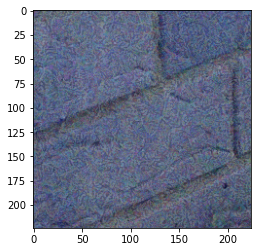

Epoch [0 / 1]:   0%|                                                                                                    | 1/60000 [00:08<140:16:18,  8.42s/it, acc=0, loss=1.92]

IMAGE : 1, LABEL : tensor([3])


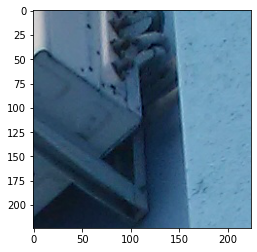

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


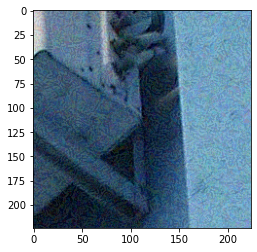

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


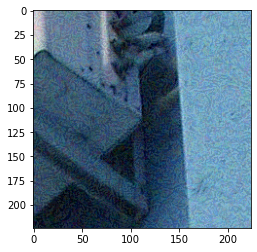

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


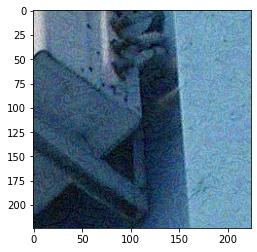

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


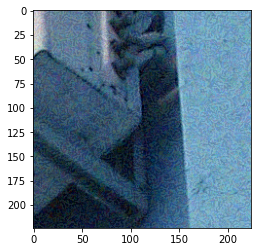

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


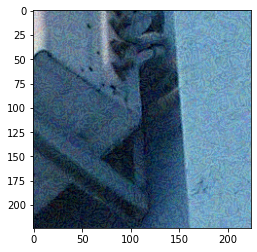

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


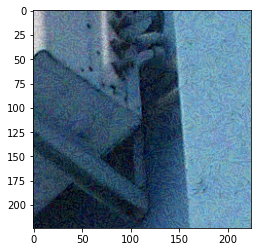

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


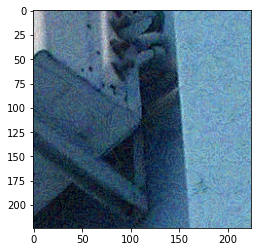

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


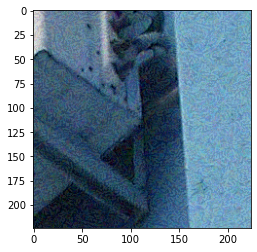

Epoch [0 / 1]:   0%|                                                                                                    | 2/60000 [00:15<123:46:41,  7.43s/it, acc=0, loss=1.94]

IMAGE : 2, LABEL : tensor([1])


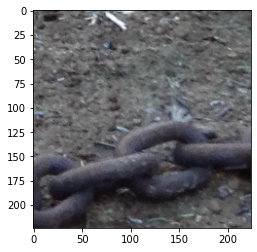

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


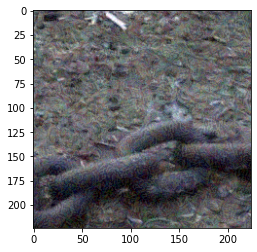

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


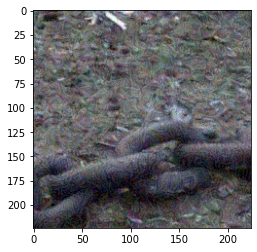

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


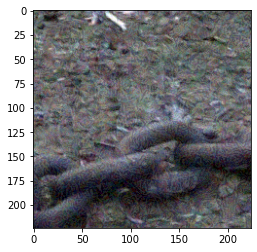

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


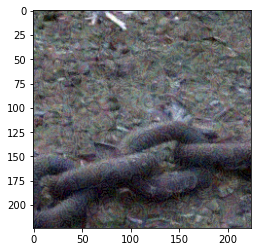

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


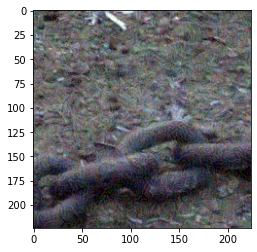

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


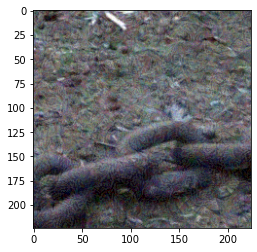

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


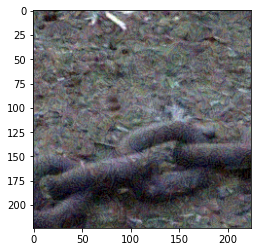

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


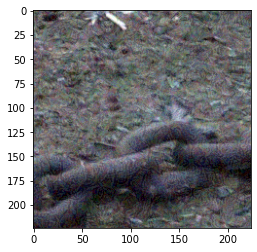

Epoch [0 / 1]:   0%|                                                                                                    | 3/60000 [00:21<114:12:33,  6.85s/it, acc=0, loss=1.94]

IMAGE : 3, LABEL : tensor([4])


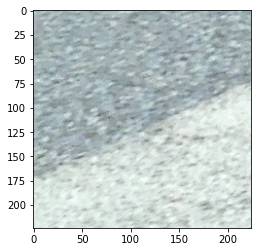

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


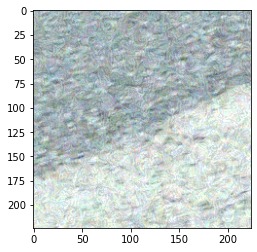

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


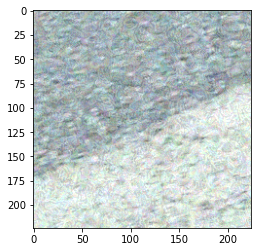

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


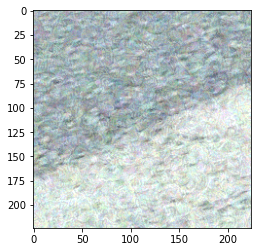

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


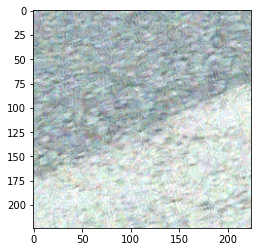

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


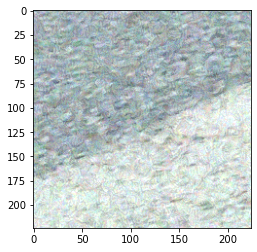

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


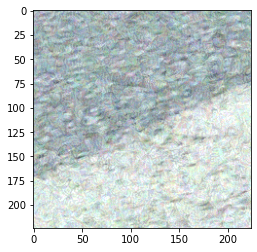

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


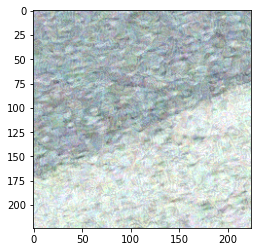

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


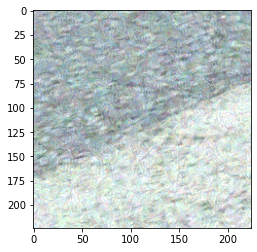

Epoch [0 / 1]:   0%|                                                                                                    | 4/60000 [00:27<112:25:12,  6.75s/it, acc=0, loss=1.91]

IMAGE : 4, LABEL : tensor([2])


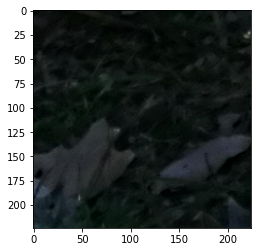

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


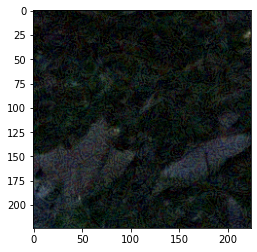

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


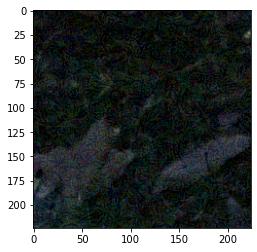

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


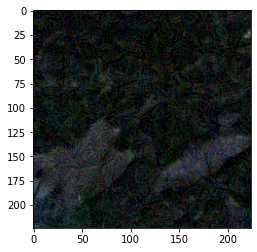

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


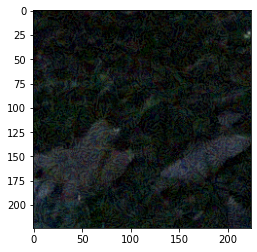

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


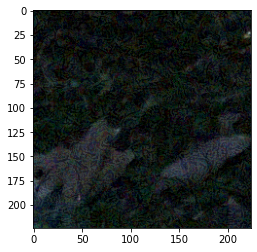

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


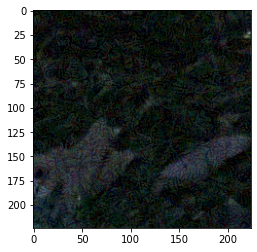

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


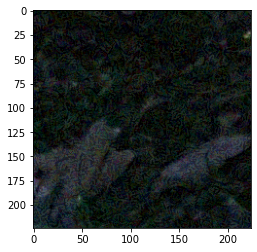

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


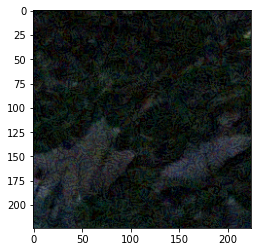

Epoch [0 / 1]:   0%|                                                                                                    | 5/60000 [00:34<115:44:55,  6.95s/it, acc=0, loss=1.84]


torch.Size([1, 3, 224, 224])
torch.Size([3, 1, 1])
INDEX : (tensor([], device='cuda:0', dtype=torch.int64),)
Robust accuracy: 0.0


In [63]:
# What to print: 
# original image, original label
# original pixel values and perturbation values
# adversarial image and predicted label after each minibatch replay

# Training
print("Starting training...")
count = 0
start_train_time = time.time()
for epoch in range(epochs):
    start_epoch_time = time.time()
    train_loss = 0
    train_acc = 0
    train_n = 0
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for i, (X, y) in loop:
        
        # how many images to check
        if count == 5:
            break
        count += 1
        
        # display the original image
        print(f'IMAGE : {i}, LABEL : {y}')
        # print(X[0])
        plt.imshow(X[0].permute(1, 2, 0).cpu().detach())
        plt.show()
        
        
        X, y = X.cuda(), y.cuda()
        if i == 0:
            first_batch = (X, y)   
            # print(X.shape)
        for m in range(minibatch_replays):
            # print(X.shape)
            output = model(X + delta[:X.size(0)])
            # print(f'PREDICTION : {output.max(1)[1]}')
            loss = criterion(output, y)
            opt.zero_grad()
#             with amp.scale_loss(loss, opt) as scaled_loss:
#                 scaled_loss.backward()
            loss.backward()
            grad = delta.grad.detach()
            delta.data = clamp(delta + epsilon * torch.sign(grad), -epsilon, epsilon)
            delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
            opt.step()
            delta.grad.zero_()
            scheduler.step()

            # display the adversarial image  
            # if m == 7:
            # print(f'Perturbation : {delta[0]}')
            adv_image = X + delta[:X.size(0)]        
            plt.imshow(adv_image[0].permute(1, 2, 0).cpu().detach())
#             fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#             fig.tight_layout(pad=3)
#             im1 = ax[0].imshow(adv_image[0].permute(1, 2, 0).cpu().detach())
#             ax[0].text(30, 30, m, bbox={'facecolor': 'white', 'pad': 10})
#             im2 = ax[1].imshow(delta[0].permute(1, 2, 0).cpu().detach())
#             ax[1].text(30, 30, m, bbox={'facecolor': 'white', 'pad': 10})
            plt.show()            

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)

        # update progress bar
        loop.set_description(f"Epoch [{epoch} / {epochs}]")
        loop.set_postfix(loss = train_loss/train_n, acc = train_acc/train_n)

    # Check current PGD robustness of model using random minibatch
    X, y = first_batch
    pgd_delta = attack_pgd(model, X, y, epsilon, pgd_alpha, 5, 1, opt)
    with torch.no_grad():
        output = model(clamp(X + pgd_delta[:X.size(0)], lower_limit, upper_limit))
    robust_acc = (output.max(1)[1] == y).sum().item() / y.size(0)
    print(f"Robust accuracy: {robust_acc}")

    epoch_time = time.time()
    lr = scheduler.get_lr()[0]

In [ ]:
# Evaluation
print('Starting evaluation...')
model_test = _densenet(pretrained=False).cuda()
model_test.load_state_dict(model.state_dict())
model_test.float()
model_test.eval()

pgd_loss, pgd_acc = evaluate_pgd(test_loader, model_test, 50, 10)
test_loss, test_acc = evaluate_standard(test_loader, model_test)

#     logger.info('Test Loss \t Test Acc \t PGD Loss \t PGD Acc')
#     logger.info('%.4f \t \t %.4f \t %.4f \t %.4f', test_loss, test_acc, pgd_loss, pgd_acc)






# try batch of 32
# vary epochs
# see why attack_pgd is not being called

In [13]:
# load and resume training of pretrained model
# you can check normal accuracy or adversarial accuracy of individual patches by commenting the corresponding block below

model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model = model.cuda()
opt = torch.optim.SGD(model.parameters(), lr=lr_max, momentum=momentum, weight_decay=weight_decay)

PATH = '/home/mtech/2020/satyaki_ghosh/codes/fastAdvTraining/fast_adversarial/VISION/train_free_output/model_13.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print(model)


# Training
print("Starting training...")
count = 0
start_train_time = time.time()
for epoch in range(epochs):
    start_epoch_time = time.time()
    train_loss = 0
    train_acc = 0
    train_n = 0
    loop = tqdm(enumerate(train_loader), total = len(train_loader))
    for i, (X, y) in loop:
        
        # how many images to check
        if count == 1:
            break
        count += 1
        
        # display the original image
#         print(f'IMAGE : {i}, LABEL : {y}')
#         # print(X[0])
#         plt.imshow(X[0].permute(1, 2, 0).cpu().detach())
#         plt.show()
        
        
        X, y = X.cuda(), y.cuda()
        if i == 0:
            first_batch = (X, y) 
            
        # Adversarial_training:    
        # for _ in range(args.minibatch_replays):
        #     output = model(X + delta[:X.size(0)])
        #     loss = criterion(output, y)
        #     opt.zero_grad()
        #     with amp.scale_loss(loss, opt) as scaled_loss:
        #         scaled_loss.backward()
        #     grad = delta.grad.detach()
        #     delta.data = clamp(delta + epsilon * torch.sign(grad), -epsilon, epsilon)
        #     delta.data[:X.size(0)] = clamp(delta[:X.size(0)], lower_limit - X, upper_limit - X)
        #     opt.step()
        #     delta.grad.zero_()
        #     scheduler.step()

        # without adv_training
        output = model(X)
        # print(f'PREDICTION : {output.max(1)[1]}')
        loss = criterion(output, y)
        opt.zero_grad()
        # loss.backward()
        # opt.step()
        # scheduler.step()          

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        train_n += y.size(0)

        # update progress bar
        loop.set_description(f"Epoch [{epoch} / {epochs}]")
        loop.set_postfix(loss = train_loss/train_n, acc = train_acc/train_n)


    # Check current PGD robustness of model using random minibatch
    X, y = first_batch
    pgd_delta = attack_pgd(model, X, y, epsilon, pgd_alpha, 5, 1, opt)
    with torch.no_grad():
        output = model(clamp(X + pgd_delta[:X.size(0)], lower_limit, upper_limit))
    robust_acc = (output.max(1)[1] == y).sum().item() / y.size(0)
    print(f"Robust accuracy: {robust_acc}")

    epoch_time = time.time()
    lr = scheduler.get_lr()[0]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Epoch [0 / 1]:   0%|                                                                                                     | 1/1875 [00:00<25:51,  1.21it/s, acc=0.219, loss=2.93]


torch.Size([32, 3, 224, 224])
torch.Size([3, 1, 1])
INDEX : (tensor([19, 26, 28, 29, 31], device='cuda:0'),)
INDEX : (tensor([], device='cuda:0', dtype=torch.int64),)
Robust accuracy: 0.0


In [ ]:
delta = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
im = plt.imshow(delta[0].permute(1, 2, 0), label = 'hfd')
e = 3
plt.text(30, 30, e, bbox={'facecolor': 'white', 'pad': 10})
plt.show()

In [ ]:
delta = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)
X = torch.zeros(1, 3, IMG_SIZE, IMG_SIZE)

adv_image = X + delta[:X.size(0)]       
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=3)
im1 = ax[0].imshow(adv_image[0].permute(1, 2, 0))
ax[0].text(30, 30, 1, bbox={'facecolor': 'white', 'pad': 10})
im2 = ax[1].imshow(delta[0].permute(1, 2, 0))
ax[1].text(30, 30, 1, bbox={'facecolor': 'white', 'pad': 10})
plt.show()  

In [19]:
from torchvision.models import densenet161
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model = model_ft.cuda()
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu